In [1]:
import cv2
import time
import math
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.morphology import skeletonize

# 경고 메시지 무시
warnings.filterwarnings(action='ignore')

# 원본 데이터(data) / 마킹 데이터(marked) / 세선화(skeletonized) 이미지를 겹침(블랜딩) 작업하여 출력하는 함수
<테스트용><br>
마킹 데이터 : 예측 데이터(pred)를 0과 1값으로 변환한 데이터<br>
세선화 데이터 : 마킹 데이터로 세선화(skeletonize)한 데이터

In [2]:
def showComplexCrack(data, marked, skeletonized):
    
    ## 데이터 전환 및 겹침(블랜딩) 수행
    data = data.reshape([448,448])
    marked = marked.reshape([448,448])
    skeletonized = skeletonized.reshape([448,448])
    
    rgb_data = []
    rgb_marked = []
    
    y_limit, x_limit = data.shape
    
    # 원본과 마킹 데이터의 0~1 값을
    # 0~255 값으로 변환
    for y in range(y_limit):
        for x in range(x_limit):
            
            # rgb값의 최대값인 255를 넘는 경우,
            # 255로 설정함
            data_rgb = data[y][x]*255
            if(data_rgb > 255):
                data_rgb = 255
                
            data_row = [int(data_rgb), int(data_rgb), int(data_rgb)]
            marked_row = [int(marked[y][x]*255), int(marked[y][x]*255), 0]
            
            rgb_data.append(data_row)
            rgb_marked.append(marked_row)
            
    rgb_data = np.array(rgb_data).reshape([448,448,3])
    rgb_marked = np.array(rgb_marked).reshape([448,448,3])
    
    # 원본 이미지에 마킹 이미지를 겹침(블랜딩)
    dst = cv2.addWeighted(rgb_data, 1, rgb_marked, 0.3, 0)
    
    # 블랜딩된 이미지에 세선화된 정보를 겹침
    for y in range(y_limit):
        for x in range(x_limit):
            
            # 세선화된 부분이면
            # 붉게 표시
            if (skeletonized[y][x] == 1):
                dst[y][x][0] = 255
                dst[y][x][1] = 100
                dst[y][x][2] = 100
                
    # 최종 블랜딩 이미지에서
    # rgb값 최대치(255) 이상인 경우, 최대치(255)값으로 설정
    over_rgb_list = np.where(dst > 255)
    
    for y, x, rgb in zip(over_rgb_list[0], over_rgb_list[1], over_rgb_list[2]):
        dst[y][x][rgb] = 255
        
        
    ## 원본과 블랜딩된 이미지 출력
    
    # pyplot의 현재 전체 이미지 크기를 백업 후 설정함
    tmp_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (10,4)
    
    # 원본 데이터 출력
    plt.subplot(1,2,1)
    plt.imshow(rgb_data)
    plt.axis('off')

    # 세선화 데이터 출력
    plt.subplot(1,2,2)
    plt.imshow(dst)
    plt.axis('off')
    
    plt.show()
    plt.close()
    
    # 백업된 pyplot 이미지 크기를 복원함
    plt.rcParams["figure.figsize"] = tmp_size

# 균열 이미지의 일정 크기(bound, default:0.25)보다 크면, 1로 만드는 함수

In [3]:
def markCrackByBound(image, bound=0.25):
    image_y, image_x = image.shape
    marked_img = np.zeros((image_y, image_x))
    
    for y in range(image_y):
        for x in range(image_x):
            if(image[y][x] > bound):
                marked_img[y][x] = 1
                
    return marked_img

# boolean 배열을 숫자(num) 배열로 변환하는 함수
skimage의 skeleetonize 후, 배열이 boolean 형태로 반환되어 이를 숫자 배열로 변경하는 용도<br><br>
True > 1<br>
False > 0

In [4]:
def bool2Num(bool_img):
    
    num_img = np.zeros(bool_img.shape)
    y_limit, x_limit = bool_img.shape
    
    for y in range(y_limit):
        for x in range(x_limit):
            if(bool_img[y][x] == True):
                num_img[y][x] = 1
        
    return num_img

# 균열 이미지에서 픽셀(Pixel) 길이를 측정하여 반환하는 함수

In [5]:
def estimateCrackPixelLength(img):
    
    # 길이 측정용 변수
    # 직선(-) 개수
    straight_cnt = 0
    # 사선(/) 개수
    diagonal_cnt = 0

    # y축 최대값과 x축 최대값
    y_limit, x_limit = img.shape
    
    for y in range(y_limit):
        for x in range(x_limit):
            
            # 현재 위치에 점이 없을 경우, 다음 픽셀 진행
            if (img[y][x] != 1):
                continue
            
            # 아래의 그림과 같이 x 점 주위의 하단과
            # 오른쪽 픽셀을 검사하여 길이를 측정함
            # -> 왼쪽 상단에서 오른쪽 하단으로 이동하며 측정을 수행하기 때문
            #
            #    x o
            #  o o o
            #
            
            #    x ●
            #  o o o
            if (x+1 < x_limit and img[y][x+1] == 1):
                straight_cnt += 1
        
            if (y+1 < y_limit):
                #     x o
                #  ● ○ ○ 
                if(x-1 >= 0 and img[y+1][x-1] == 1):
                    diagonal_cnt += 1

                #     x o
                #  ○ ● ○
                if(img[y+1][x] == 1):
                    straight_cnt += 1

                #    x o
                #  ○ ○ ●
                if(x+1 < x_limit and img[y+1][x+1] == 1):
                    diagonal_cnt += 1

    # 균열 길이 계산
    pixel_length = straight_cnt + (math.sqrt(2) * diagonal_cnt)
    
    return pixel_length

# 분석할 데이터 로딩
<데이터 구조><br>
train_list : 학습용 데이터(이미지 개수, 448, 448, 1)<br>
label_list : 학습용 라벨 데이터(이미지 개수, 448, 448, 1)

In [6]:
print("data loading...")

data_list = np.load("/src/data/crack/masked/images.npy")
print("data loading complete.")
print(data_list.shape)

data loading...
data loading complete.
(11298, 448, 448, 1)


(1, 448, 448, 1)


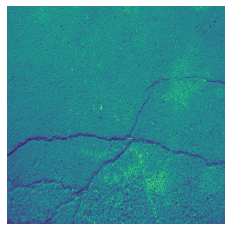

In [7]:
data_list = cv2.resize(data_list[1], dsize=(448,448))
data_list = data_list.reshape(1,448,448,1)
print(data_list.shape)

plt.imshow(data_list.reshape(448,448))
plt.axis('off')

plt.show()
plt.close()

In [12]:
data_list = cv2.imread('concrete_test_1.png', cv2.IMREAD_COLOR)
data_list = cv2.cvtColor(data_list, cv2.COLOR_BGR2GRAY)
data_list = cv2.resize(data_list, dsize=(448,448))
data_list = np.array(data_list).reshape(1,448,448,1)
data_list = data_list/data_list.max()

print(data_list.shape)

(1, 448, 448, 1)


# 분석 모델 로딩 및 결과 출력

START: /src/hyebin/model/CRACK-UNET-11
INFO:tensorflow:Restoring parameters from /src/hyebin/model/CRACK-UNET-11/variables/variables

END: /src/hyebin/model/CRACK-UNET-11, elapsed: 0
pixel (area, length, width): (1122.000000, 122.396970, 9.166894)


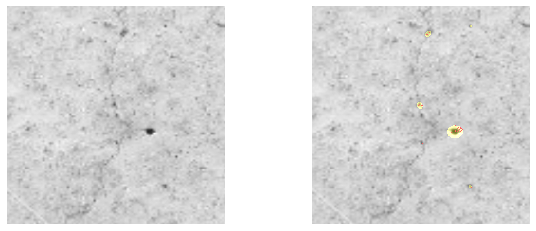

In [13]:
# 분석 모델 디렉토리명
modeldir = "/src/hyebin/model/CRACK-UNET-11"
base_idx = 0
pred_cnt = 1

# 세션 생성
with tf.Session(graph=tf.Graph()) as sess:
    
    # 모델 로딩
    print("START: " + modeldir)
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], modeldir)
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("in:0")
    pred = graph.get_tensor_by_name("pred:0")
    
    # 모델 분석 수행
    start_time = time.time()
    _pred = sess.run([pred], feed_dict={x:data_list[base_idx:base_idx+pred_cnt]})
    _pred = np.array(_pred)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print("\nEND: %s, elapsed: %d"%(modeldir, elapsed_time))
    
    # 결과 출력
    for idx in range(pred_cnt):
        
        # 예측 데이터의 픽셀을 0과 1로 변환
        marked = markCrackByBound(_pred[0][idx].reshape([448,448]))
        # 세선화
        skeletonized = bool2Num(skeletonize(marked))
        
        # 균열 넓이, 길이, 평균 폭 계산
        pixel_area = len(np.where(marked > 0)[0])
        pixel_length = estimateCrackPixelLength(skeletonized)
        if(pixel_length != 0):
            pixel_width = pixel_area/pixel_length
        else:
            pixel_width = 0
            
        print("pixel (area, length, width): (%f, %f, %f)"%(pixel_area, pixel_length, pixel_width))
        showComplexCrack(data_list[base_idx+idx], marked, skeletonized)